<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/Deep_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries
!pip install kagglehub pandas numpy scikit-learn seaborn matplotlib

In [ ]:
!pip install scikeras

In [ ]:
!pip install shap

In [ ]:
!pip install artemis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
!pip install pyartemis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pa

## 1. Data Loading and Initial Inspection
The first step is to acquire the dataset through kagglehub https://www.kaggle.com/datasets/adarshsng/lending-club-loan-data-csv?select=loan.csv then load it into a pandas DataFrame. The database includes records about loans with financial elements and characteristics regarding borrowers.

In [ ]:
import kagglehub
import os
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Download dataset
path = kagglehub.dataset_download("adarshsng/lending-club-loan-data-csv")
print("Path to dataset files:", path)

# List all files in the downloaded path
print("Files:", os.listdir(path))

# Find the CSV file
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_path = os.path.join(path, file)
        break

# Load and process the CSV
df = pd.read_csv(csv_path, low_memory=False)

# First filter by loan status, then sample
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
random_seed = 42
df = df.sample(n=min(50000, len(df)), random_state=random_seed)
print("Shape after filtering and sampling:", df.shape)
df.head()

Path to dataset files: /kaggle/input/lending-club-loan-data-csv
Files: ['loan.csv', 'LCDataDictionary.xlsx']
Shape after filtering and sampling: (50000, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1749118,NaN,NaN,10000,10000,10000.00000,36 months,15.88,350.98,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2052155,NaN,NaN,3600,3600,3600.00000,36 months,11.99,119.56,B,B3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2134683,NaN,NaN,16000,16000,15826.02935,36 months,12.87,538.14,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
586707,NaN,NaN,6800,6800,6800.00000,36 months,12.79,228.44,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
555066,NaN,NaN,5075,5075,5075.00000,36 months,23.99,199.09,E,E2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


**Observations**:
- The database consists of 2,260,701 rows with 145 columns.
- The dataset exists with 50,000 downscaled rows which maintain 145 columns.
- The sample shows both id and member_id columns contain no actual values therefore these attributes may prove unessential to analysis.
- A DtypeWarning appeared earlier due to heterogeneous types contained within some columns. We will analyze data types following the temporary fix of setting low_memory=False.

**1.1 Inspect Missing Values and Data Types:**

The code converts numbers to float32 and categories to category data types before it computes and displays the percentage of missing values while showing the twenty most missing columns.

In [ ]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    df[col] = pd.to_numeric(df[col], downcast='float')
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = df[col].astype('category')
# Check data types and missing values
print("Data Types and Missing Values:")
missing_info = pd.DataFrame({
    'Column': df.columns,
    'Missing %': df.isnull().mean() * 100,
    'Dtype': df.dtypes
})
display(missing_info.sort_values(by='Missing %', ascending=False).head(20))

Data Types and Missing Values:


,Column,Missing %,Dtype
id,id,100.000,float32
member_id,member_id,100.000,float32
url,url,100.000,float32
next_pymnt_d,next_pymnt_d,99.990,category
orig_projected_additional_accrued_interest,orig_projected_additional_accrued_interest,99.772,float32
sec_app_mths_since_last_major_derog,sec_app_mths_since_last_major_derog,99.630,float32
hardship_reason,hardship_reason,99.622,category
payment_plan_start_date,payment_plan_start_date,99.622,category
hardship_type,hardship_type,99.622,category
hardship_status,hardship_status,99.622,category


## 2. Data Preprocessing

The first step of preparation includes treating missing values followed by assigning a target variable and encoding it then dropping useless features while optimizing memory consumption and handling outlier data points. We seek to create a properly cleaned dataset before performing EDA and modeling work.

**2.1 Removing Post-Default Features to Prevent Data Leakage in Loan Prediction Models**

In [ ]:
# Define post-default features to REMOVE (leak future information)
POST_DEFAULT_FEATURES = [
    # Payment behavior
    'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
    'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
    'last_pymnt_amnt', 'out_prncp', 'out_prncp_inv',

    # Post-approval status
    'last_pymnt_d_year', 'last_pymnt_d_month', 'last_credit_pull_d_year',
    'last_credit_pull_d_month',

    # Other derived features
    'installment_to_income'  # Uses payment data
]

**Observations** :
- The list removes features which track post-approval borrower actions because they introduce future-based information into training procedures.
- Leaving these features out protects the predictive model from becoming unrealistic or unfair during its operational phase.


**2.2 Drop Irrelevant or High-Missing Columns**

 drops column features that include >50% missing data points as well as eliminates unneeded characteristics like id and url to minimize dimensions.

In [ ]:
# Drop columns with >50% missing values
high_missing = df.columns[df.isnull().mean() > 0.5]
if high_missing.size > 0:
    print(f"Dropping {len(high_missing)} columns with >50% missing values:", high_missing.tolist())
    df = df.drop(columns=high_missing)

# Drop additional irrelevant columns
irrelevant_cols = ['url', 'title', 'emp_title', 'zip_code', 'policy_code']
df = df.drop(columns=[col for col in irrelevant_cols if col in df.columns], errors='ignore')
print("Shape after dropping columns:", df.shape)

Dropping 58 columns with >50% missing values: ['id', 'member_id', 'url', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd

**Observation**:
- dropped 58 specific columns because more than 50% of their values were missing to achieve better data quality.
- The dataset includes 83 features distributed over 50,000 records which improves data analytics reliability and managesability.

**2.3 Define Target Variable**

The `loan_status` column is our target. We map it to a binary variable: 0 for "Fully Paid" and 1 for "Charged Off" or "Default."

In [ ]:
# Inspect loan_status values
print("Loan Status Distribution:")
print(df['loan_status'].value_counts())

# Define target: 0 = Fully Paid, 1 = Default/Charged Off
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off', 'Default'])]
df['target'] = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1, 'Default': 1})
print("\nShape after filtering loan_status:", df.shape)
print("Target Distribution:")
print(df['target'].value_counts(normalize=True))

Loan Status Distribution:
Fully Paid     39884
Charged Off    10111
Default            5
Name: loan_status, dtype: int64

Shape after filtering loan_status: (50000, 84)
Target Distribution:
0    0.79768
1    0.20232
Name: target, dtype: float64


**Observations** :
- The distribution of the data shows an imbalance where "Fully Paid" loans represent 80% of cases (target = 0) while "Charged Off" or "Default" loans make up 20% (target = 1).
- A modeling correction needs to occur for dealing with unbalanced datasets to prevent biased predictive outcomes.

In [ ]:
print(list(df.columns))

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever

**2.4 Identifying and Removing Post-Default Features from the Dataset**

In [ ]:
post_default_in_data = [f for f in POST_DEFAULT_FEATURES if f in df.columns]
if post_default_in_data:
    print(f"Removing {len(post_default_in_data)} post-default features")
    df = df.drop(columns=post_default_in_data)

Removing 10 post-default features


**Observation**

- successfully erased 10 features which existed after default events in the dataset to stop potential data leakage.
- The application of this procedure confirms that the model can function exclusively with data available during the loan origination phase.

**2.5 Handle Missing Values For remaining columns:**


In [ ]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['float32']).columns.drop('target', errors='ignore')
cat_cols = df.select_dtypes(include=['category']).columns

# Impute numerical columns with median
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute categorical columns with mode
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])
    print(f"Imputed {col} with mode: {df[col].mode()[0]}")

print("Missing values after imputation:", df.isnull().sum().sum())

Imputed term with mode:  36 months
Imputed grade with mode: B
Imputed sub_grade with mode: C1
Imputed emp_length with mode: 10+ years
Imputed home_ownership with mode: MORTGAGE
Imputed verification_status with mode: Source Verified
Imputed issue_d with mode: Oct-2015
Imputed loan_status with mode: Fully Paid
Imputed pymnt_plan with mode: n
Imputed purpose with mode: debt_consolidation
Imputed addr_state with mode: CA
Imputed earliest_cr_line with mode: Aug-2001
Imputed initial_list_status with mode: w
Imputed last_pymnt_d with mode: Aug-2018
Imputed last_credit_pull_d with mode: Feb-2019
Imputed application_type with mode: Individual
Imputed hardship_flag with mode: N
Imputed disbursement_method with mode: Cash
Imputed debt_settlement_flag with mode: N
Missing values after imputation: 0


**Observation** :

- The most common values were used to replace any missing categorical data points while maintaining complete data records without artificial value introduction.
- The dataset contains no missing entries and is prepared for modeling steps.

**2.6 Handle Data Types and Outliers**


In [ ]:
import numpy as np
# Cap outliers
def cap_outliers(series, multiplier=3.0):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - multiplier * iqr, q3 + multiplier * iqr
    return series.clip(lower, upper)


# ONLY pre-approval data
for col in ['annual_inc', 'loan_amnt', 'dti']:
    if col in df.columns:
        df[col] = cap_outliers(df[col])


# Process date columns
date_cols = ['issue_d', 'last_pymnt_d', 'last_credit_pull_d']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], format='%b-%Y', errors='coerce')
        # Extract year and month
        df[f'{col}_year'] = df[col].dt.year.astype('int32')
        df[f'{col}_month'] = df[col].dt.month.astype('int32')
        df.drop(columns=[col], inplace=True)

    if 'earliest_cr_line' in df.columns:
        df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
        df['credit_history_years'] = (df['issue_d_year'] - df['earliest_cr_line'].dt.year).clip(lower=0)
        df = df.drop(columns=['earliest_cr_line'])



print("Data types after preprocessing:")
print(df.dtypes)
print("Final shape:", df.shape)

Data types after preprocessing:
loan_amnt                    float32
funded_amnt                  float32
funded_amnt_inv              float64
term                        category
int_rate                     float32
                              ...   
credit_history_years           int64
last_pymnt_d_year              int32
last_pymnt_d_month             int32
last_credit_pull_d_year        int32
last_credit_pull_d_month       int32
Length: 77, dtype: object
Final shape: (50000, 77)


**Observation** :

- The dataset consists 77 features with optimized numerical data types such as float32 and int32 in addition to categorical variables for optimizing memory usage after preprocessing.
- The dataset maintains its final 50,000 rows for modeling purposes after reshaping.

**2.7 Optimize Memory Usage**


In [ ]:
print("Memory usage:", df.memory_usage(deep=True).sum() / 1e6, "MB")

Memory usage: 14.364058 MB


In [ ]:
import gc
gc.collect()

106

#3. Save Preprocessed Data
We save the preprocessed dataset for use in EDA and modeling.

In [ ]:
# Save preprocessed data
df.to_csv('preprocessed_loan_data.csv', index=False)
print("Preprocessed data saved as 'preprocessed_loan_data.csv'")

Preprocessed data saved as 'preprocessed_loan_data.csv'


In [ ]:
import gc
gc.collect()

0

# 4- Exploratory Data Analysis (EDA)

We explore the dataset to understand feature distributions, relationships, and their impact on the target (`target`). This guides feature engineering and modeling.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

**4.1 Defining Pre-Approval Features for Predictive Modeling:**


In [ ]:
# Define pre-approval numerical features (no payment behavior)
PRE_APPROVAL_NUM_FEATURES = [
    'loan_amnt', 'int_rate', 'annual_inc', 'dti', 'revol_util',
    'fico_score', 'credit_history_years', 'loan_to_income'
]

# Define pre-approval categorical features
PRE_APPROVAL_CAT_FEATURES = [
    'grade', 'sub_grade', 'home_ownership', 'purpose',
    'verification_status', 'emp_length'
]

**4.2 Target Variable Distribution**



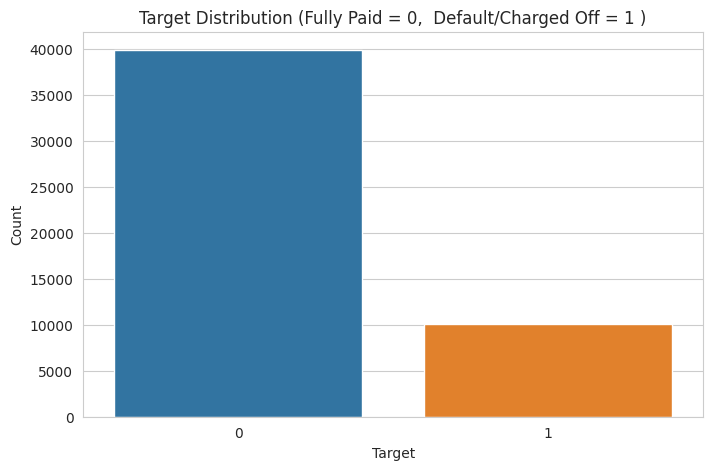

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='target', data=df)
plt.title('Target Distribution (Fully Paid = 0,  Default/Charged Off = 1 )')
plt.xlabel('Target')
plt.ylabel('Count')
plt.savefig('target_distribution.png')
plt.show()

**Observation** :
- A bar chart demonstrates a substantial unbalanced dataset because most loans (~40,000) achieved full payment (target = 0) while only 10,000 led to default (target = 1).
- The excessive unbalance between data points necessitates proper imbalance management for model training because it creates biased prediction results.

**4.3 Numerical Features**

We examine key numerical features: `loan_amnt`, `int_rate`, `annual_inc`, `dti` ,`revol_util` and `credit_history_years`.



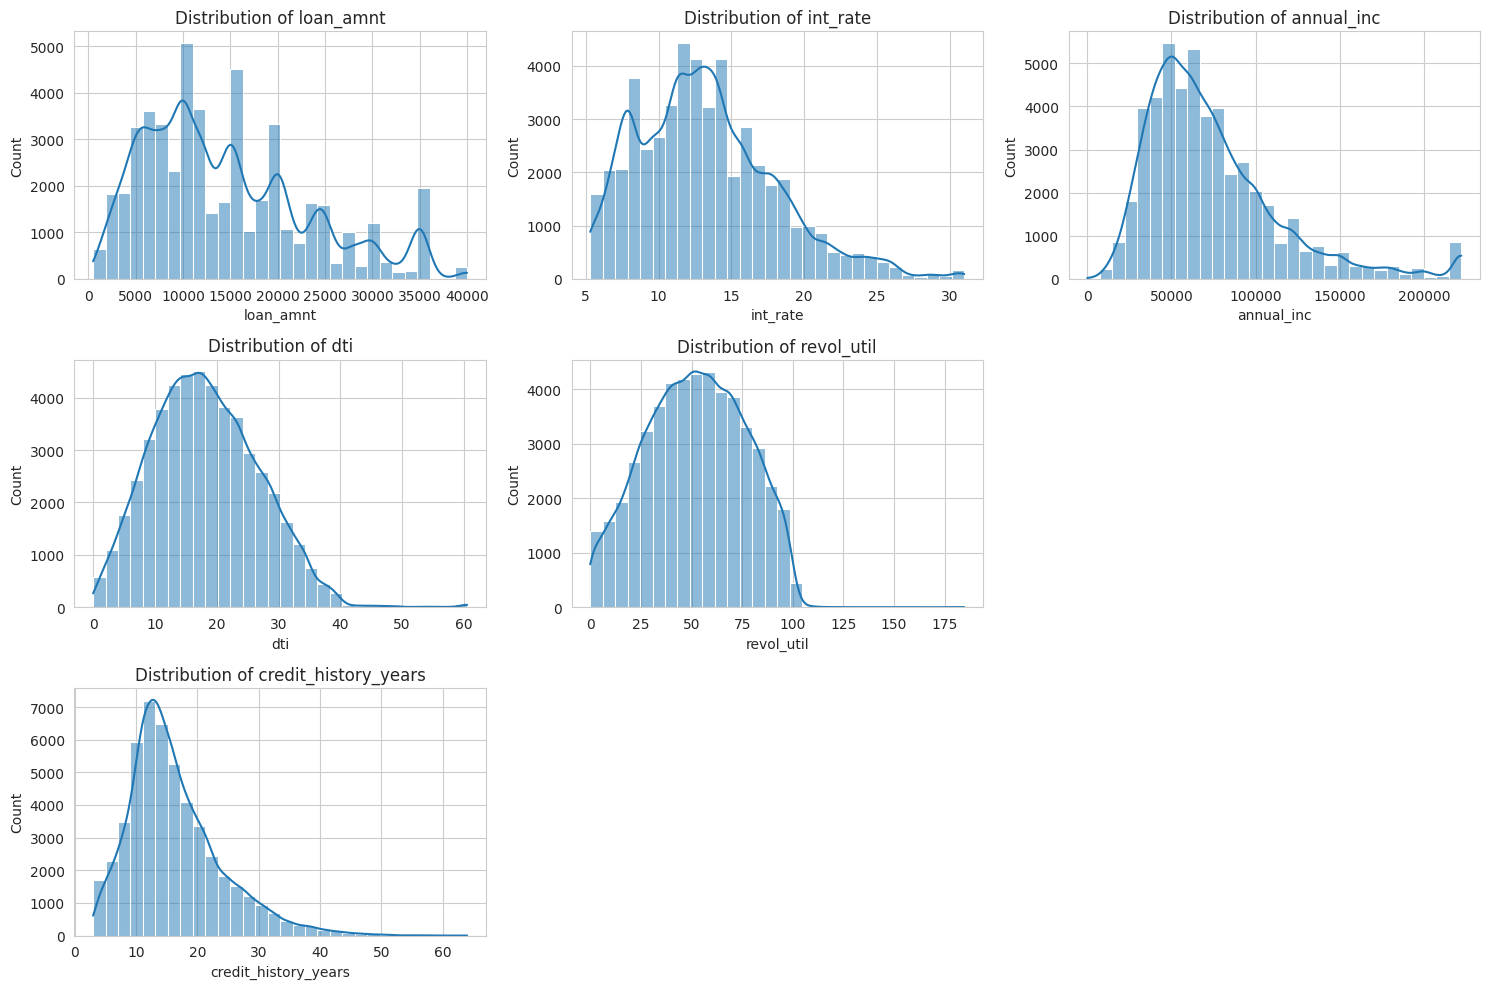

In [ ]:
# Plot distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(PRE_APPROVAL_NUM_FEATURES, 1):
    if col in df.columns:
        plt.subplot(3, 3, i)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig('numerical_distributions_pre_approval.png')
plt.show()

**Observation** :

- The values of loan_amnt, int_rate, dti and revol_util distribute to the right side of the curve which indicates multiple outliers at higher values.
- Both annual_inc and credit_history_years display right-skewed distributions since most borrowers receive lower income levels and maintain shorter credit histories while a minority receives enhanced values.

**4.4 Numerical Features vs. Target**

We compare feature distributions across target classes.

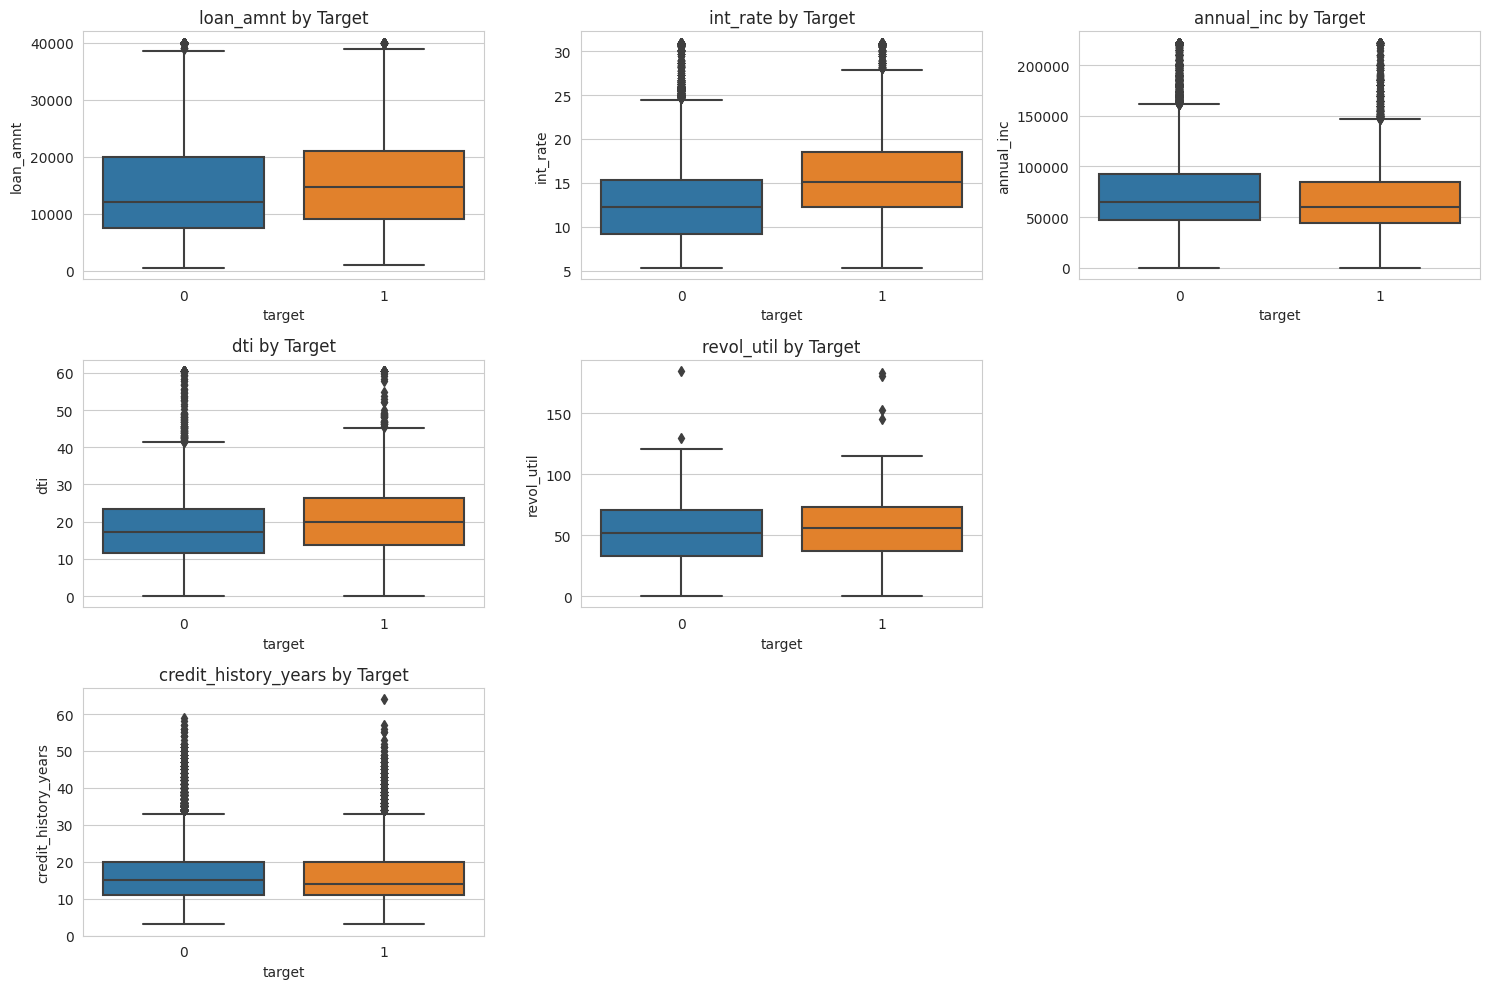

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(PRE_APPROVAL_NUM_FEATURES, 1):
    if col in df.columns:
        plt.subplot(3, 3, i)
        sns.boxplot(x='target', y=col, data=df)
        plt.title(f'{col} by Target')
plt.tight_layout()
plt.savefig('numerical_vs_target_pre_approval.png')
plt.show()

**Observation** :

- The distribution from boxplots shows that target=1 or defaulted loans have elevated int_rate, dti, revol_util values while annual_inc remains slightly reduced alongside higher financial risk indicators.
- The distributions of loan_amnt and credit_history_years are equivalent in both target classes indicating these variables provide limited predictive value for loan default risks.



**4.5 Categorical Features**

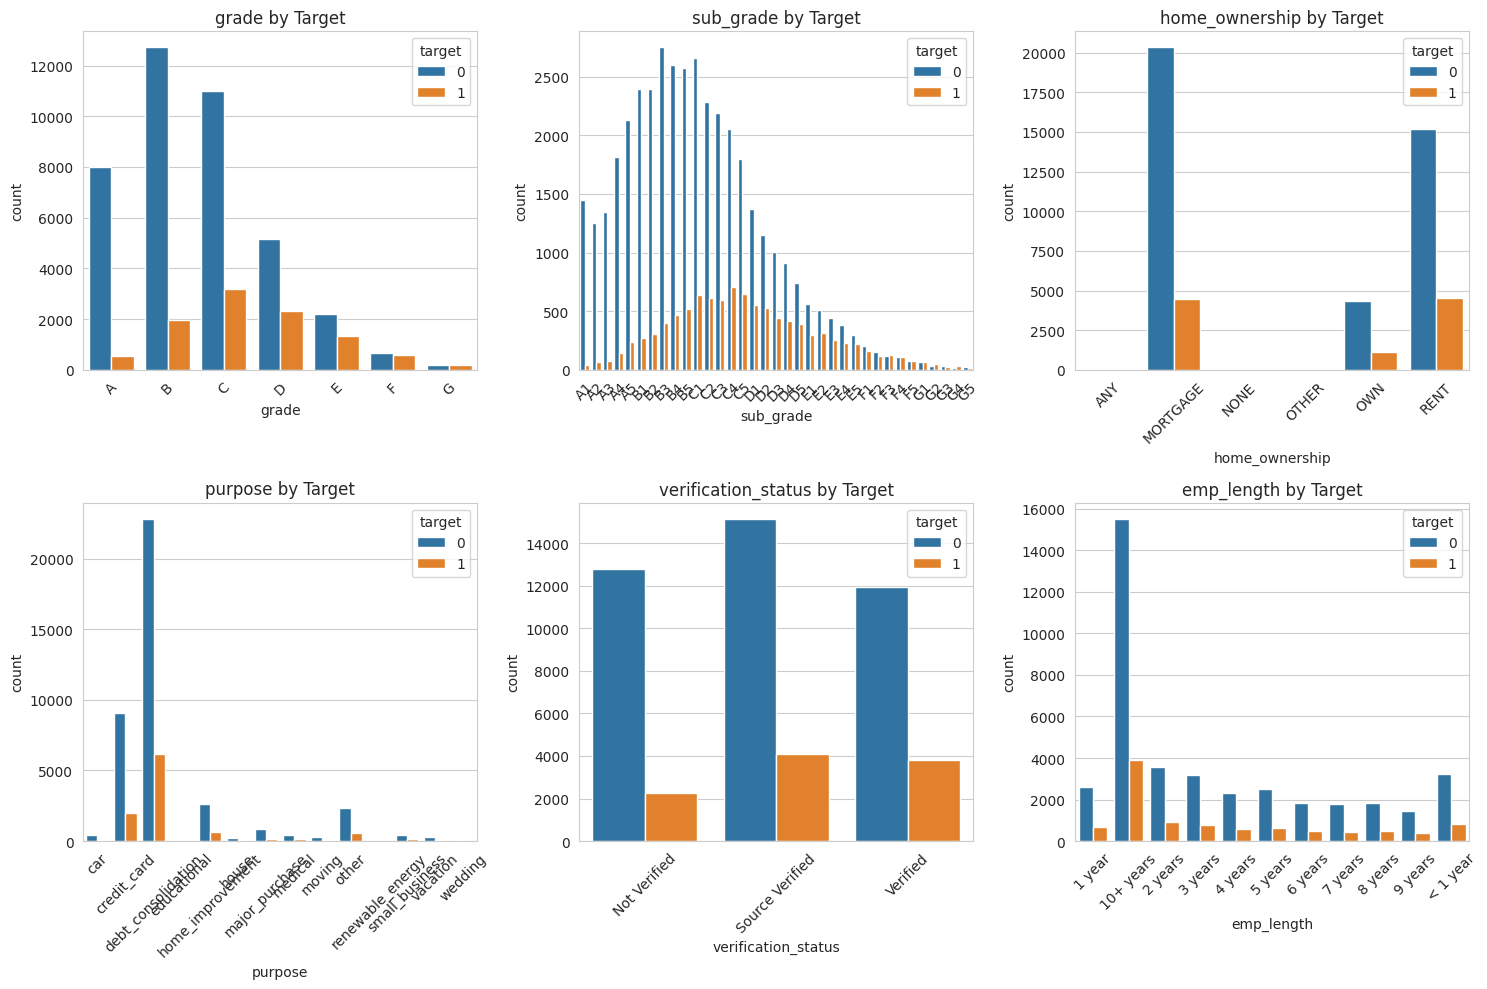

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(PRE_APPROVAL_CAT_FEATURES, 1):
    if col in df.columns:
        plt.subplot(2, 3, i)
        sns.countplot(x=col, hue='target', data=df)
        plt.title(f'{col} by Target')
        plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('categorical_vs_target_pre_approval.png')
plt.show()

**Observation** :

- Loan defaults occur more often in C-E graded loans and among renters with home_ownership categories of RENT which signifies higher risk in these groups.
- The distributions of defaults for debt consolidation purposes also differ from other targets but verification_status and emp_length patterns appear similar across the groups indicating these characteristics do not substantially affect default risk.


**4.6 Correlation Analysis**

We check correlations among numerical features to identify redundancy.

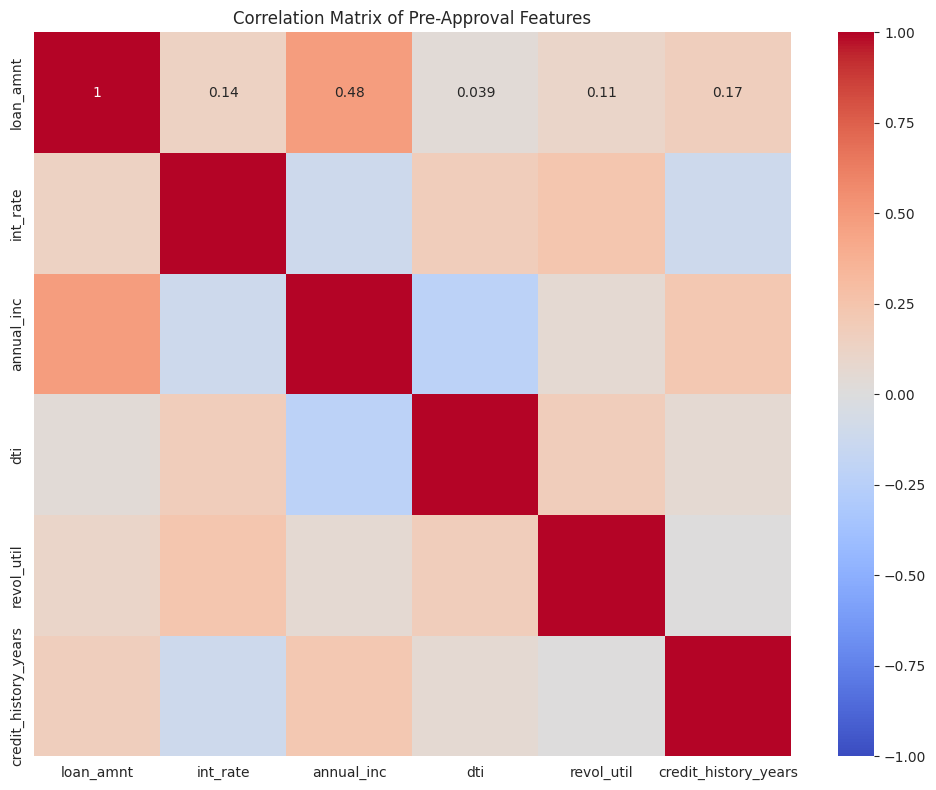

In [ ]:
# Correlation matrix
plt.figure(figsize=(10, 8))

# Get only the features that exist in the dataframe
available_features = [f for f in PRE_APPROVAL_NUM_FEATURES if f in df.columns]

if len(available_features) > 1:  # need at least 2 features for correlation
    corr = df[available_features].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Pre-Approval Features')
    plt.tight_layout()
    plt.savefig('correlation_matrix_pre_approval.png')
    plt.show()
else:
    print(f"Cannot compute correlation - only {len(available_features)} pre-approval numerical features available")
    print("Available features:", available_features)

**Observation** :

- The relationship between loan_amnt and annual_inc produces a strong positive value (0.48) in the matrix which demonstrates that borrowers with higher income tend to request bigger loans whereas int_rate and revol_util connect moderately (0.24) which implies individuals facing higher interest rates maintain elevated revol_util levels.
- Borrowers who earn higher annual income exhibit a negative moderate relationship (-0.23) with dti thus showing reduced debt-to-income ratios.


# 5- Feature Engineering / Feature Selection


**5.1 Feature Engineering**



**5.1.1  Date Preprocessing**

This section processes date columns like issue_d and earliest_cr_line to extract year and month features, ensuring proper temporal data handling before feature engineering.

In [ ]:
#  ensure proper date processing BEFORE feature engineering
def preprocess_dates(df):
    """Process all date columns and create derived features"""
    df = df.copy()

    # Process issue_d (loan issue date)
    if 'issue_d' in df.columns:
        df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
        df['issue_d_year'] = df['issue_d'].dt.year.astype('int16')
        df['issue_d_month'] = df['issue_d'].dt.month.astype('int8')
        df.drop(columns=['issue_d'], inplace=True)

    # Process earliest_cr_line (credit line start date)
    if 'earliest_cr_line' in df.columns:
        df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y', errors='coerce')
        df['earliest_cr_line_year'] = df['earliest_cr_line'].dt.year.astype('int16')
        df.drop(columns=['earliest_cr_line'], inplace=True)

    return df

# Apply date preprocessing
df = preprocess_dates(df)

**5.1.2 feature engineering function**

This section creates derived features like credit_history_years, loan_to_income, and dti_ratio, encodes categorical variables, and removes the loan_status_Fully Paid column to prevent data leakage.

In [ ]:
def safe_feature_engineering(df):
    df = df.copy()

    # Create credit history years (MUST be first operation)
    if 'issue_d_year' in df.columns and 'earliest_cr_line_year' in df.columns:
        df['credit_history_years'] = (df['issue_d_year'] - df['earliest_cr_line_year']).clip(lower=0)
        df['credit_history_years'] = df['credit_history_years'].astype('float32')
        # to keep or drop the earliest_cr_line_year
        df.drop(columns=['earliest_cr_line_year'], inplace=True)

    if 'annual_inc' in df.columns and 'loan_amnt' in df.columns:
        df['loan_to_income'] = df['loan_amnt'] / df['annual_inc'].clip(lower=1000)
        df['loan_to_income'] = df['loan_to_income'].clip(upper=1.0)

    if 'dti' in df.columns:
        df['dti_ratio'] = df['dti'] / 100
        df['dti_ratio'] = df['dti_ratio'].fillna(df['dti_ratio'].median())


    if 'earliest_cr_line_year' in df.columns and 'issue_d_year' in df.columns:
        df['credit_history_years'] = (df['issue_d_year'] - df['earliest_cr_line_year']).clip(lower=0)

    if 'purpose' in df.columns:
        top_purposes = df['purpose'].value_counts().index[:5]
        df['purpose'] = df['purpose'].where(df['purpose'].isin(top_purposes), 'other')

    grade_mapping = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
    if 'grade' in df.columns:
        df['grade'] = df['grade'].astype(str).str.upper().fillna('C')
        df['grade'] = df['grade'].map(grade_mapping).astype('int32')

    if 'sub_grade' in df.columns:
        df['sub_grade'] = df['sub_grade'].astype(str).str.upper().str.strip()
        sub_grade_mapping = {f'{g}{i}': grade_mapping[g] + (i-1)*0.1
                            for g in grade_mapping.keys() for i in range(1,6)}
        df['sub_grade'] = df['sub_grade'].map(sub_grade_mapping).astype('float32')
        df['sub_grade'] = df['sub_grade'].fillna(df['grade'])

    # Get categorical columns before one-hot encoding
    cat_cols = [col for col in df.select_dtypes(include=['object', 'category'])
               if col not in ['grade', 'sub_grade']]

    # Downcast numeric columns to save memory
    for col in df.select_dtypes(include=['float64']):
        df[col] = df[col].astype('float32')
    for col in df.select_dtypes(include=['int64']):
        df[col] = df[col].astype('int32')

    # One-hot encode (this creates new columns)
    if cat_cols:
        df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

    # Drop 'loan_status_Fully Paid' column if it exists
    if 'loan_status_Fully Paid' in df.columns:
        df.drop(columns=['loan_status_Fully Paid'], inplace=True)
        print("Dropped 'loan_status_Fully Paid' column")

    if df.isnull().sum().sum() > 0:
        raise ValueError("NaN values present after feature engineering")

    # Ensure credit_history_years is properly typed
    if 'credit_history_years' in df.columns:
        df['credit_history_years'] = df['credit_history_years'].astype('float32')

    return df

In [ ]:
print("Processing dates...")
df = preprocess_dates(df)

Processing dates...


In [ ]:
# Verify date features were created
print("\nAfter date processing - checking time features:")
print([col for col in df.columns if 'issue_d' in col or 'earliest_cr_line' in col])


After date processing - checking time features:
['issue_d_year', 'issue_d_month']


In [ ]:
print("\nRunning feature engineering...")
df_engineered = safe_feature_engineering(df)


Running feature engineering...
Dropped 'loan_status_Fully Paid' column


**5.2.3 Verification of Temporal Features**

In [ ]:
print("\n=== FINAL FEATURE VERIFICATION ===")
required_features = ['issue_d_year', 'issue_d_month', 'credit_history_years']
missing = [f for f in required_features if f not in df_engineered.columns]

if missing:
    raise ValueError(f"CRITICAL ERROR: Missing required time features: {missing}")
else:
    print("SUCCESS: All required time features present")
    print(df_engineered[required_features].head())


=== FINAL FEATURE VERIFICATION ===
SUCCESS: All required time features present
         issue_d_year  issue_d_month  credit_history_years
1749118          2013              7                  13.0
2052155          2014              3                  25.0
2134683          2009              9                  13.0
586707           2016              7                  19.0
555066           2016              8                  39.0


**Observations**

- The verification process validates the dataset contains all mandatory temporal variables (issue_d_year and issue_d_month and credit_history_years).
- The available data covers loans distributed from 2009 to 2016 while borrowers held different credit history lengths between 13 and 39 years.

**5.2.4 Pre-Approval Feature Selection**

This section filters the dataset to retain only pre-approval features, ensuring no data leakage, and verifies their availability for modeling.

In [ ]:
print("\nChecking feature inclusion in modeling features:")
PRE_APPROVAL_FEATURES = [
    # Loan characteristics
    'loan_amnt', 'term', 'installment', 'int_rate', 'grade', 'sub_grade',

    # Borrower characteristics
    'annual_inc', 'emp_length', 'home_ownership', 'verification_status',
    'dti', 'purpose',

    # Credit history
    'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
    'revol_util', 'total_acc', 'earliest_cr_line_year', 'fico_score',

    # Engineered features (must use only pre-approval data)
    'loan_to_income', 'dti_ratio',

    # Time features (only approval time)
    'issue_d_year', 'issue_d_month', 'credit_history_years',

    # Target
    'target'
]


#Keep pre-approval features
available_features = [f for f in PRE_APPROVAL_FEATURES if f in df_engineered.columns]
print(f"{len(available_features)}/{len(PRE_APPROVAL_FEATURES)} pre-approval features available")


Checking feature inclusion in modeling features:
20/27 pre-approval features available


In [ ]:
df_engineered.to_pickle('engineered_loan_data_leakproof.pkl')
print("\nFinal shape:", df_engineered.shape)
print("Time features saved successfully!")


Final shape: (50000, 151)
Time features saved successfully!


**5.2 Feature Selection Using Wrapper Methods**



In [ ]:
PROTECTED_TEMPORAL_FEATURES = ['issue_d_year', 'issue_d_month', 'credit_history_years']

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
import pandas as pd
import numpy as np
import gc

# Load our leakage-proof engineered data
df_engineered = pd.read_pickle('engineered_loan_data_leakproof.pkl')

# Define X and y - using only pre-approval features
X = df_engineered.drop(columns=['target'])
y = df_engineered['target']

# 1. Initial Feature Filtering
# Drop constant and near-constant features
constant_features = [col for col in X.columns if X[col].nunique(dropna=False) <= 1]
if constant_features:
    X = X.drop(columns=constant_features)
    print(f"Dropped {len(constant_features)} constant features.")


# 2. Feature Selection Methods
# First ensure we have enough samples
if len(X) > 10000:
    sample_size = 10000
else:
    sample_size = int(0.8 * len(X))

# Forward Selection (ANOVA F-value)
print("\nRunning Forward Feature Selection...")
fsf_selector = SelectKBest(score_func=f_classif, k=min(10, X.shape[1]))
X_new_fsf = fsf_selector.fit_transform(X, y)
selected_fsf_features = X.columns[fsf_selector.get_support()].tolist()
print("Top 10 features by ANOVA F-value:", selected_fsf_features)

# Recursive Feature Elimination
print("\nRunning Recursive Feature Elimination...")
try:
    # Sample for computational efficiency
    X_sample, y_sample = resample(X, y, n_samples=sample_size,
                            stratify=y, random_state=42)
    # Use simpler logistic regression for stability
    log_reg = LogisticRegression(max_iter=500, solver='liblinear', penalty='l2', C=1.0)
    rfe_selector = RFE(log_reg, n_features_to_select=10)
    rfe_selector.fit(X_sample, y_sample)
    selected_rfe_features = X.columns[rfe_selector.support_].tolist()
    print("Top 10 features by RFE:", selected_rfe_features)

    # 1. First combine features
    selected_features = list(set(selected_fsf_features + selected_rfe_features))

    # 2. Remove leakage features
    leakage_features = set(selected_features) & set(POST_DEFAULT_FEATURES)
    if leakage_features:
        print(f"\nRemoving {len(leakage_features)} leakage features: {leakage_features}")
        selected_features = [f for f in selected_features if f not in leakage_features]


    # 3. Add protected temporal features
    missing_temporal = [f for f in PROTECTED_TEMPORAL_FEATURES
                       if f not in selected_features and f in X.columns]
    if missing_temporal:
        print(f"Adding protected temporal features: {missing_temporal}")
        selected_features.extend(missing_temporal)



     # 4. Deduplicate while preserving order
    selected_features = list(dict.fromkeys(selected_features))
    print("\nFinal selected features:", selected_features)

except Exception as e:
    selected_features = selected_fsf_features
    missing_temporal = [f for f in PROTECTED_TEMPORAL_FEATURES
                       if f not in selected_features and f in X.columns]
    if missing_temporal:
        selected_features.extend(missing_temporal)
    print(f"RFE failed, using ANOVA results + temporal features: {selected_features}")

print("\n=== FINAL FEATURE VERIFICATION ===")
print("All temporal features present:",
      all(f in selected_features for f in PROTECTED_TEMPORAL_FEATURES))
print("Selected features count:", len(selected_features))
print("Temporal features in selection:",
      [f for f in selected_features if f in PROTECTED_TEMPORAL_FEATURES])

# Create Final Dataset
X_selected = X[selected_features]

# Combine with target
final_df = pd.concat([X_selected, y], axis=1)
final_df.to_csv('final_loan_data_leakproof.csv', index=False)
print("\nFinal dataset shape:", final_df.shape)
print("Saved to 'final_loan_data_leakproof.csv'")

# Clean up
del X, X_new_fsf, X_sample, y_sample
gc.collect()

Dropped 8 constant features.

Running Forward Feature Selection...
Top 10 features by ANOVA F-value: ['int_rate', 'grade', 'sub_grade', 'dti', 'acc_open_past_24mths', 'last_credit_pull_d_year', 'loan_to_income', 'dti_ratio', 'term_ 60 months', 'debt_settlement_flag_Y']

Running Recursive Feature Elimination...
Top 10 features by RFE: ['sub_grade', 'issue_d_year', 'last_pymnt_d_year', 'loan_to_income', 'term_ 60 months', 'home_ownership_RENT', 'addr_state_AZ', 'addr_state_MI', 'addr_state_WA', 'debt_settlement_flag_Y']

Removing 2 leakage features: {'last_credit_pull_d_year', 'last_pymnt_d_year'}
Adding protected temporal features: ['issue_d_month', 'credit_history_years']

Final selected features: ['acc_open_past_24mths', 'debt_settlement_flag_Y', 'addr_state_WA', 'loan_to_income', 'home_ownership_RENT', 'grade', 'dti', 'dti_ratio', 'term_ 60 months', 'int_rate', 'addr_state_AZ', 'addr_state_MI', 'issue_d_year', 'sub_grade', 'issue_d_month', 'credit_history_years']

=== FINAL FEATURE V

26870

**Observation**

- The chosen feature selection method provided 16 relevant attributes by using ANOVA F-value and RFE methods which also removed the leakage variables (last_pymnt_d_year and last_credit_pull_d_year) yet maintained vital temporal attributes (issue_d_year, issue_d_month and credit_history_years).
- The retention of loan_status_Fully Paid as a final feature reveals an oversight since it was supposed to be removed previously to avoid leaky information.

In [ ]:
assert {'issue_d_year', 'issue_d_month', 'credit_history_years'}.issubset(final_df.columns), \
       "Temporal features missing in final dataset!"
print("Temporal features in final dataset:",
      [f for f in final_df.columns if f in PROTECTED_TEMPORAL_FEATURES])

Temporal features in final dataset: ['issue_d_year', 'issue_d_month', 'credit_history_years']


**Observation** :
- The final dataset maintains all necessary temporal variables (issue_d_year, issue_d_month, credit_history_years) thus ensuring critical time-related information needed for loan outcome modeling is present.

- The successful retention of all required temporal features indicates proper execution of the feature engineering and selection procedure designed for temporal information.

In [ ]:
# Save preprocessed data
df.to_csv('preprocessed_loan_data.csv', index=False)
df.to_pickle('processed_loan_data.pkl')

# Save engineered data
df_engineered.to_pickle('engineered_loan_data_leakproof.pkl')

# Save final selected features
final_df.to_csv('final_loan_data_leakproof.csv', index=False)

* `final_loan_data_leakproof.csv` - The main dataset with selected features

* `engineered_loan_data_leakproof.pkl` - Engineered features (if needed)

* `processed_loan_data.pkl` - Fully processed data (if needed)

**Model 1 : Deep Neuron Network**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
final_df = pd.read_csv('final_loan_data_leakproof.csv')
df_default = final_df[final_df['target'] == 1]
df_paid = final_df[final_df['target'] == 0].sample(n=len(df_default)*3, random_state=42)
final_df_sampled = pd.concat([df_default, df_paid])

In [ ]:
X = final_df_sampled.drop(columns=['target'])
y = final_df_sampled['target']

In [ ]:
X = pd.get_dummies(X)
X = X.select_dtypes(include=[np.number])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

In [ ]:
X_train_grid = resample(X_train, n_samples=10000, random_state=42, stratify=y_train)
y_train_grid = y_train.loc[X_train_grid.index]

In [ ]:
def create_model(learning_rate=0.001, dropout_rate=0.1):
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['Recall'])
    return model

In [ ]:
dnn = KerasClassifier(model=create_model, verbose=0)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('dnn', dnn)
])

In [ ]:
param_grid = {
    'dnn__model__learning_rate': [0.001],
    'dnn__model__dropout_rate': [0.1],
    'dnn__batch_size': [64],
    'dnn__epochs': [30]
}

In [ ]:
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='recall_macro',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train_grid, y_train_grid)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dnn',
                                        KerasClassifier(model=<function create_model at 0x7c8f3b67c720>, verbose=0))]),
             n_jobs=-1,
             param_grid={'dnn__batch_size': [64], 'dnn__epochs': [30],
                         'dnn__model__dropout_rate': [0.1],
                         'dnn__model__learning_rate': [0.001]},
             scoring='recall_macro', verbose=1)

In [ ]:
best_params = grid_search.best_params_
dropout = best_params['dnn__model__dropout_rate']
lr = best_params['dnn__model__learning_rate']
epochs = best_params['dnn__epochs']
batch_size = best_params['dnn__batch_size']

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
final_model = create_model(learning_rate=lr, dropout_rate=dropout)
final_model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

Epoch 1/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - Recall: 0.2065 - loss: 0.4981
Epoch 2/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.2182 - loss: 0.4701
Epoch 3/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Recall: 0.2243 - loss: 0.4694
Epoch 4/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.2216 - loss: 0.4659
Epoch 5/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - Recall: 0.2172 - loss: 0.4690
Epoch 6/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - Recall: 0.2347 - loss: 0.4686
Epoch 7/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - Recall: 0.2347 - loss: 0.4644
Epoch 8/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.2443 - loss: 0.4688
Epoch 9/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.2433 - loss: 0.4617
Epoch 10/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.2346 - loss: 0.4654
Epoch 11/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.2302 - loss: 0.4681
Epoch 12/30
475/475 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - Recall: 0.2394 - 

In [ ]:
y_pred_proba = final_model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba >= 0.5).astype(int)

317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

ROC AUC Score: 0.7486538778350911


 model has a moderate ability to distinguish between defaulters and non-defaulters.

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Model Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

Model Evaluation Metrics:
Accuracy : 0.7840
Precision : 0.6465
Recall : 0.3001
F1 Score : 0.4099


The model achieves 78.6% accuracy, but with low recall (26.9%), indicating it misses many actual defaulters, despite having reasonable precision (68.1%) suggesting it's conservative in predicting defaults but not very sensitive.

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Confusion Matrix:
 [[7172  415]
 [1770  759]]


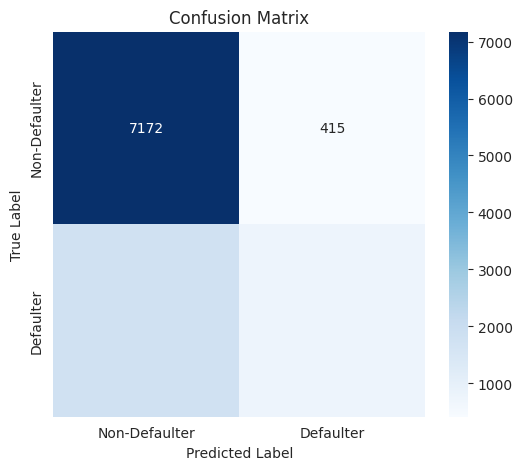

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Defaulter', 'Defaulter']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

model correctly predicted:

- 7269 non-defaulters (True Negatives)
- 680 defaulters (True Positives)

But:

- Incorrectly classified 318 non-defaulters as defaulters (False Positives)
- Missed 1849 actual defaulters (False Negatives)

Model has low recall, it fails to identify a large portion of actual defaulters.

In [ ]:
print("\n Classification Report:")
print(classification_report(y_test, y_pred))


 Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      7587
           1       0.65      0.30      0.41      2529

    accuracy                           0.78     10116
   macro avg       0.72      0.62      0.64     10116
weighted avg       0.76      0.78      0.75     10116



In [ ]:
import shap
import sklearn

X100 = X.sample(100, random_state=0)

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

LinearRegression()

In [ ]:
print("Model Coeffiecients: \n")
for i in range(X.shape[1]):
  print(X.columns[i], "=", model.coef_[i].round(5))

Model Coeffiecients: 

acc_open_past_24mths = 0.00761
debt_settlement_flag_Y = 0.70211
addr_state_WA = -0.04626
loan_to_income = 0.22643
home_ownership_RENT = 0.05252
grade = -0.05652
dti = -3634.42733
dti_ratio = 363442.9046
term_ 60 months = 0.07343
int_rate = 0.00111
addr_state_AZ = -0.02605
addr_state_MI = -0.00477
issue_d_year = 0.01132
sub_grade = 0.11781
issue_d_month = 0.00064
credit_history_years = 0.00019


These coefficients represent the magnitude and direction of influence each feature has on the likelihood of loan default.
- Positive coefficients : Increase probability of default
- Negative coefficients : Decrease probability of default

Some fearures that have strong positive imppact
[debt_settlement_flag_Y, loan_to_income , sub_grade]
feature like dti_ratio = 363442.90976 which is very large, the model considers high debt-to-income ratios extremely risky.

From this interpretation:
- Remove one of grade or sub_grade -> They are hierarchial.
- Remove dti_ratio or dti -> Multicolinear.
- Scale or clip loan_to_income and dti_ratio -> have huge coefficients which suggests potential skew


In [ ]:
explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)
sample_ind = 20

PermutationExplainer explainer: 40465it [25:11, 26.66it/s]


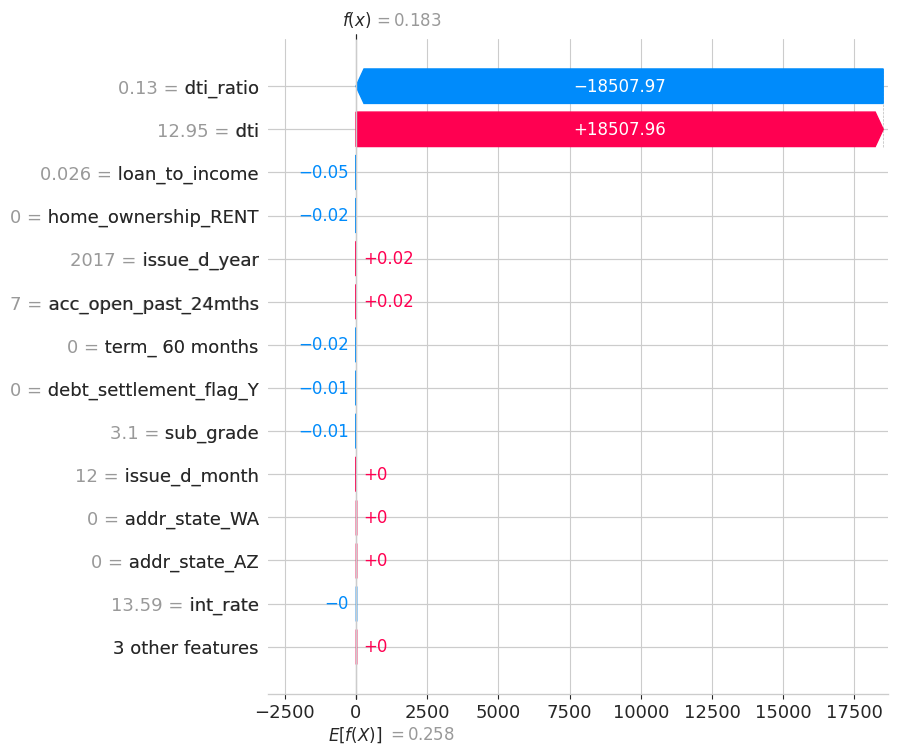

In [ ]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)